In [13]:
import numpy as np
import pandas as pd
import os
import glob
import unicodedata
import nltk
import re
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.cm as cm
from matplotlib import rcParams
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import pandas
import seaborn as sns 
import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sp
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model



import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

nltk.download('punkt')
nltk.download('omw')
nltk.download('wordnet')
nltk.download('stopwords')

review_col = "review_description"
rating_col = "rating"


df = pd.read_excel('train_subset.xlsx')

print(df.head(10))

stopwords_list_arabic = stopwords.words('arabic')
# stopwords_list_english = stopwords.words('english')
print(stopwords_list_arabic,'\n')


Num GPUs Available:  0


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\20112\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw to
[nltk_data]     C:\Users\20112\AppData\Roaming\nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\20112\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\20112\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                  review_description  rating
0  شركه زباله و سواقين بتبرشم و مفيش حتي رقم للشك...      -1
1  خدمة الدفع عن طريق الكي نت توقفت عندي اصبح فقط...       1
2  تطبيق غبي و جاري حذفه ، عاملين اكواد خصم و لما...      -1
3  فعلا تطبيق ممتاز بس لو فى امكانية يتيح لمستخدم...       1
4  سيء جدا ، اسعار رسوم التوصيل لا تمت للواقع ب ص...      -1
5  قعد عشرين سنة يدور على سائق بس اما عن توصيل ال...       0
6                                         احلئ تطبيق       1
7                                      رائع واو مدهش       1
8  مکو بس البحرین وعمان وغیرهه بس العراق مکو یعنی...      -1
9                    تطبيق جميل يستاهل الخمس نجوم👍👍👍       1
['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر', 'ألا', 'إلا', 'التي', 'الذي', 'الذين', 'اللاتي', 'اللائي', 'اللتان', 'اللتيا', 'اللتين', 'اللذان', 'اللذين', 'اللواتي', 'إلى', 'إليك', 'إليكم', 'إليكما', 'إليكن', 'أم', 'أما', 'أما', 'إما', 'أن', 'إن', 'إنا', 'أنا', 'أنت', 'أنتم', 'أنتما', 'أنتن', 'إنما', 'إنه', 'أنى', 'أنى', 'آ

In [14]:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)


def remove_emojis(text):
  return ''.join(c for c in text if not unicodedata.combining(c))

def is_english_word(word) :
    alpha = "abcdefghijklmnopqrtuvwxyz"
    for i in word:
        if i in alpha :
            return True
    return False


def remove_punctuations(word):
    arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
    english_punctuations = string.punctuation
    punctuations_list = arabic_punctuations + english_punctuations
    translator = str.maketrans('', '', punctuations_list)
    return word.translate(translator)


def preprocess_review(sentence):
    sentence = str(sentence)
    words = wordpunct_tokenize(sentence)
    non_english_words = [word for word in words if not is_english_word(word)]
    cleaned_sentence = ' '.join(non_english_words)
    
    cleaned_sentence = remove_emojis(cleaned_sentence)
    cleaned_sentence = normalize_arabic(cleaned_sentence)
    cleaned_sentence = remove_repeating_char(cleaned_sentence)
    cleaned_sentence = remove_punctuations(cleaned_sentence)
    
    return cleaned_sentence

def preprocess_dataframe(df, review_col=review_col):
    tokenizer = RegexpTokenizer(r'\w+')
    df[review_col] = df[review_col].apply(preprocess_review)
    df[review_col] = df[review_col].apply(tokenizer.tokenize)
    df[review_col] = df[review_col].apply(lambda x: [item for item in x if item not in stopwords_list_arabic])



In [15]:
# print(df.head(30))
preprocess_dataframe(df);
print(df.head(30))


                                   review_description  rating
0   [شركه, زباله, سواقين, بتبرشم, مفيش, حتي, رقم, ...      -1
1   [خدمه, الدفع, طريق, الكي, نت, توقفت, عندي, اصب...       1
2   [تطبيق, غبي, جاري, حذفه, عاملين, اكواد, خصم, ن...      -1
3   [فعلا, تطبيق, متاز, امكانيه, يتيح, لمستخدم, ال...       1
4   [سيء, جدا, اسعار, رسوم, التوصيل, تمت, لواقع, صله]      -1
5   [قعد, سنه, يدور, علي, سائق, اما, توصيل, الاشيا...       0
6                                       [احلئ, تطبيق]       1
7                                        [رائع, مدهش]       1
8   [مکو, البحرین, وعمان, وغیره, العراق, مکو, یعنی...      -1
9                  [تطبيق, جميل, يستاهل, الخمس, نجوم]       1
10                                            [طلبات]       1
11                         [الاسمر, عمار, الريق, مصر]       1
12  [متاز, ومصدقه, ودقه, وسرعه, التوصيل, الرجاء, و...       1
13                                  [هالبرنامج, منقذ]       1
14             [مره, سريع, جاني, الطلب, انصح, بصراحه]       1
15      

Length of 'positive' column Before: 1172
Length of 'negative' column Before: 725
Length of 'neutral' column Before: 102
5973 total words in positive, with a vocabulary size of 2596


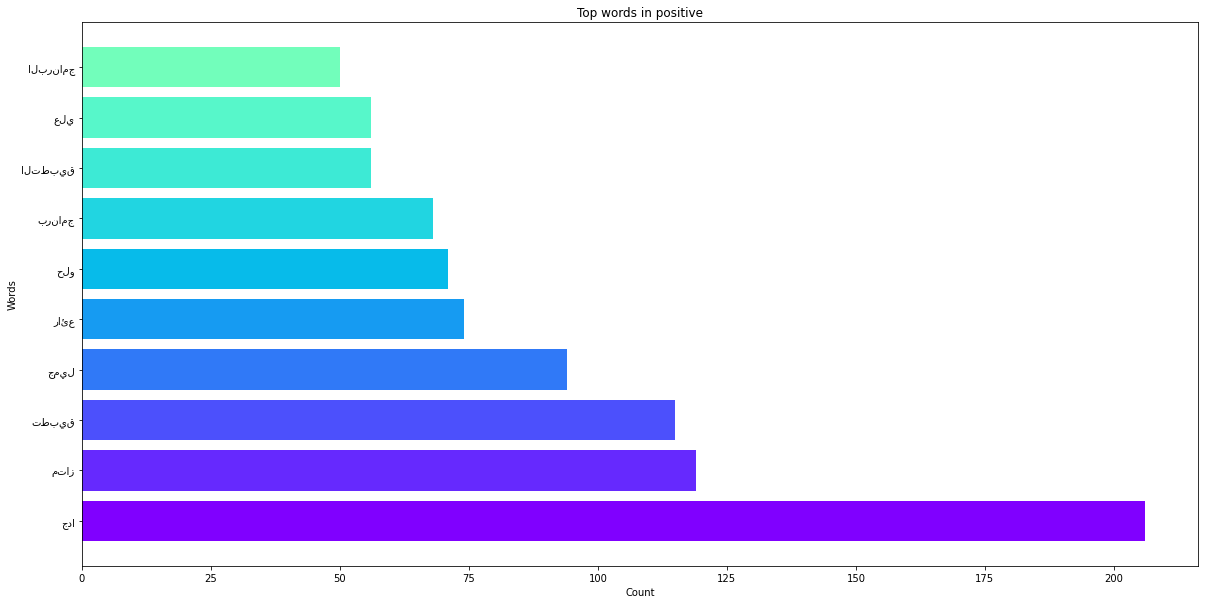

951 total words in neutral, with a vocabulary size of 706


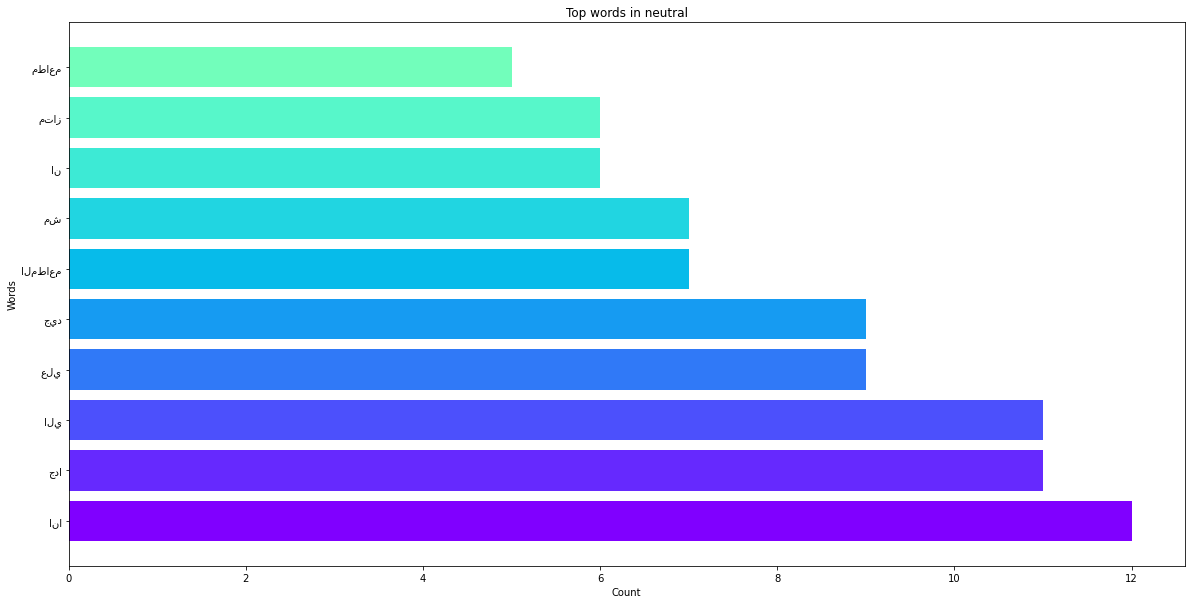

8719 total words in negative, with a vocabulary size of 3682


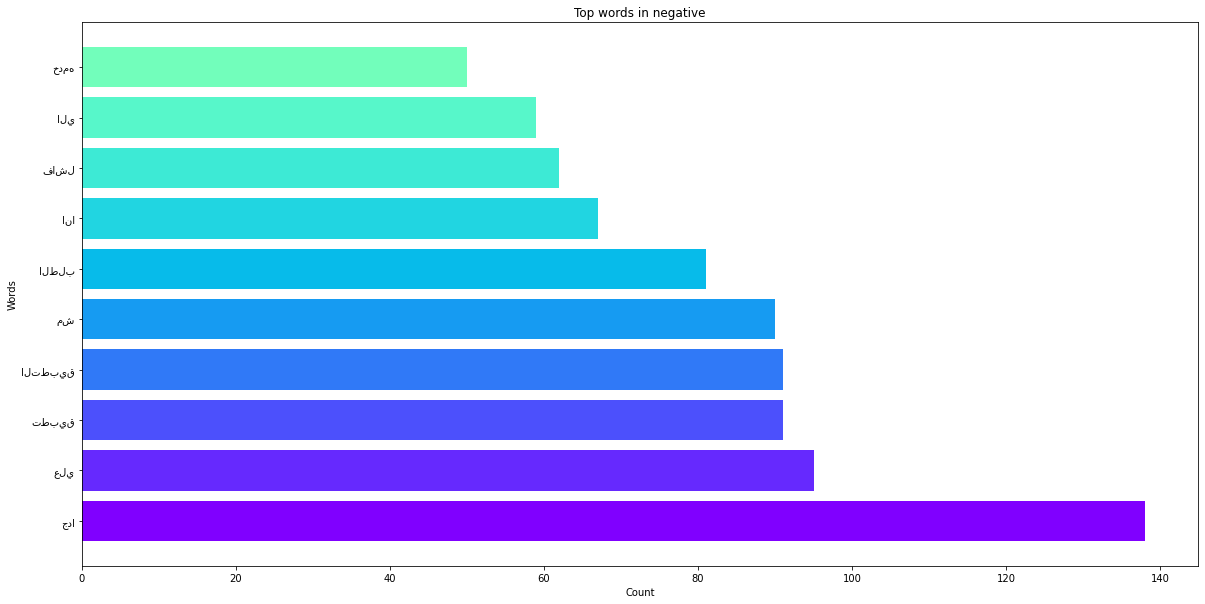

Total Words in TOTal 6984


In [16]:
pos = []
neg = []
neu = []

df[rating_col] = df[rating_col].replace({-1: 0, 0: 1, 1: 2})

for i in range(len(df[rating_col])) : 
    if df[rating_col][i] == 1:
        neu.append(df[review_col][i])

    if df[rating_col][i] == 2:
        pos.append(df[review_col][i])

    if df[rating_col][i] == 0:
        neg.append(df[review_col][i])



# Display the updated DataFrame Before
print(f"Length of 'positive' column Before: {len(pos)}")
print(f"Length of 'negative' column Before: {len(neg)}")
print(f"Length of 'neutral' column Before: {len(neu)}")


def display_stats(col,col_name):
    all_words = []

    for sentence in col :
        for word in sentence :
            all_words.append(word)

    VOCAB = sorted(list(set(all_words)))

    print(f"%s total words in {col_name}, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))

    counter = Counter(all_words)
    counter.most_common(35)


    counted_words = Counter(all_words)

    words = []
    counts = []
    for letter, count in counted_words.most_common(10):
        words.append(letter)
        counts.append(count)

    colors = cm.rainbow(np.linspace(0, 1, 20))
    rcParams['figure.figsize'] = 20, 10

    plt.title('Top words in ' + col_name)
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.barh(words, counts, color=colors)
    plt.show()

    return len(VOCAB)



tot_words = 0
for col in [(pos,"positive"), (neu,"neutral"), (neg,"negative")]:
    tot_words += display_stats(col[0] ,col[1] )

print("Total Words in TOTal " + str(tot_words))

In [17]:
# Create new columns 'positive', 'negative', and 'neutral' based on the 'rating' column
# Identify the two minimum lengths
min_lengths = sorted([len(pos), len(neg), len(neu)])[:2]


num_duplicates = max(min_lengths) - len(neu)
duplicated_rows = df[df[rating_col] == 1].sample(n=num_duplicates, replace=True)
df = pd.concat([df, duplicated_rows], ignore_index=True)


# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the updated DataFrame After
print(f"Length of 'positive' column After: {len(df[df[rating_col]== 2])}")
print(f"Length of 'negative' column After: {len(df[df[rating_col] == 0])}")
print(f"Length of 'neutral' column After: {len(df[df[rating_col] == 1])}")

print(df.head(20))

Length of 'positive' column After: 1172
Length of 'negative' column After: 725
Length of 'neutral' column After: 725
                                   review_description  rating
0                                   [السرعه, التسليم]       2
1   [جون, العراق, يجون, السعودي, الامارات, الكويت,...       2
2   [متاز, مكتوب, التوصيل, مجاني, ليه, تاخذون, رسو...       2
3   [التطبيق, مشكله, يتم, تنزيله, وفي, مره, رساله,...       0
4                                               [جيد]       1
5                    [بنقل, فرد, افراد, العائله, معا]       1
6   [تطبيق, جيد, انا, برا, الاردن, بدي, سجل, حساب,...       0
7                                               [احل]       2
8   [جماعه, مشكله, التحديث, بيفتح, معايا, عملت, تح...       1
9                                  [تطبيق, جيد, كثير]       2
10       [زفت, مش, عاوز, يوصل, لمكان, الي, انا, ساكن]       0
11                        [تطبيق, جميل, ويوصل, بسرعه]       2
12  [مش, عايز, يفتح, يقولو, هنبعتلك, كود, مش, بتبع...       0
13  [انا, عندي,

In [18]:
for i in range(len(df[review_col])) :
    df[review_col][i] = ' '.join(df[review_col][i])
    


max_words = 5000 # top x most frequent words
max_len = 200 # max sentece len, it will truncate

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df[review_col])
sequences = tokenizer.texts_to_sequences(df[review_col])
data = pad_sequences(sequences, maxlen=max_len)

y = np.array(df[rating_col])
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")


print(type(data))
print(f"rows : {len(data)} \n cols : {len(data[0])} \n")

C:\Users\20112\AppData\Local\Temp/ipykernel_34956/1546499575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[review_col][i] = ' '.join(df[review_col][i])


<class 'numpy.ndarray'>
rows : 2622 
 cols : 200 



In [19]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))
model1.summary()


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy')

# X_train, X_test, y_train, y_test = train_test_split(data,labels, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=42)


checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(data, labels, epochs=70,callbacks=[checkpoint1])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          100000    
                                                                 
 lstm (LSTM)                 (None, 15)                2160      
                                                                 
 dense (Dense)               (None, 3)                 48        
                                                                 
Total params: 102208 (399.25 KB)
Trainable params: 102208 (399.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch 1/70

82/82 [==============================] - 7s 55ms/step - loss: 1.0499
Epoch 2/70
82/82 [==============================] - 4s 53ms/step - loss: 0.9934
Epoch 3/70
82/82 [==============================] - 4s 52ms/step - loss: 0.9282
Epoch 4/70
82/82 [===================

In [20]:
# Save the model to an HDF5 file
model1.save('my_model.h5')

# Load the saved model (optional)
loaded_model = load_model('my_model.h5')

c:\Users\20112\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
